In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append("/home/truggles/Inter-annual_Variability_Residual_Load")
from helpers import return_file_info_map

In [2]:
def get_temp_file(ba):
    ba_info = return_file_info_map( ba )
    df = pd.read_csv(f"../{ba_info['temp'][0]}")
    df['yr_local'] = df['year'].shift(periods=-1*ba_info['to_local'])
    df['hr_local'] = df['hour'].shift(periods=-1*ba_info['to_local'])
    df['day_local'] = df['day'].shift(periods=-1*ba_info['to_local'])
    df = df.loc[ (df['yr_local'] >= ba_info['years'][0]) & (df['year'] <= ba_info['years'][-1]) ]
    df = df.reset_index()
    df = df.drop(['index',], axis=1)
    print(df.head(10))
    return df

def get_demand_file(ba):

    ba_info = return_file_info_map( ba )
    df = pd.read_csv(f"../{ba_info['demand'][0]}")
    df['yr_local'] = df['year'].shift(periods=-1*ba_info['to_local'])
    df['hr_local'] = df['hour'].shift(periods=-1*ba_info['to_local'])
    df['day_local'] = df['day'].shift(periods=-1*ba_info['to_local'])
    df = df.loc[ (df['yr_local'] >= ba_info['years'][0]) & (df['year'] <= ba_info['years'][-1]) ]
    df = df.reset_index()
    df = df.drop(['index',], axis=1)
    print(df.head(10))
    return df

In [3]:
BAs = ['ERCOT',]

for ba in BAs:
    dem = get_demand_file(ba)
    temp = get_temp_file(ba)
    print(len(dem.index))
    print(len(temp.index))

   year  month  day  hour   demand (MW)  yr_local  hr_local  day_local
0  2003      1    1     7  25850.693856    2003.0       1.0        1.0
1  2003      1    1     8  25715.345849    2003.0       2.0        1.0
2  2003      1    1     9  25594.664511    2003.0       3.0        1.0
3  2003      1    1    10  25608.883747    2003.0       4.0        1.0
4  2003      1    1    11  25982.213157    2003.0       5.0        1.0
5  2003      1    1    12  26710.030756    2003.0       6.0        1.0
6  2003      1    1    13  27536.923830    2003.0       7.0        1.0
7  2003      1    1    14  27751.817094    2003.0       8.0        1.0
8  2003      1    1    15  27574.560821    2003.0       9.0        1.0
9  2003      1    1    16  27254.141975    2003.0      10.0        1.0
   year  month  day  hour      temp  yr_local  hr_local  day_local
0  2003      1    1     7  4.656797    2003.0       1.0        1.0
1  2003      1    1     8  4.162095    2003.0       2.0        1.0
2  2003      1    

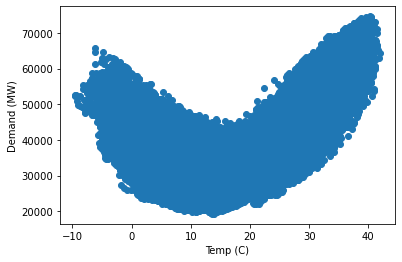

In [4]:
fig, ax = plt.subplots()
ax.scatter(temp['temp'], dem['demand (MW)'])
ax.set_xlabel('Temp (C)')
ax.set_ylabel('Demand (MW)')
plt.show()

In [5]:
print(dem.head())
print(temp.head())

   year  month  day  hour   demand (MW)  yr_local  hr_local  day_local
0  2003      1    1     7  25850.693856    2003.0       1.0        1.0
1  2003      1    1     8  25715.345849    2003.0       2.0        1.0
2  2003      1    1     9  25594.664511    2003.0       3.0        1.0
3  2003      1    1    10  25608.883747    2003.0       4.0        1.0
4  2003      1    1    11  25982.213157    2003.0       5.0        1.0
   year  month  day  hour      temp  yr_local  hr_local  day_local
0  2003      1    1     7  4.656797    2003.0       1.0        1.0
1  2003      1    1     8  4.162095    2003.0       2.0        1.0
2  2003      1    1     9  3.751599    2003.0       3.0        1.0
3  2003      1    1    10  3.437346    2003.0       4.0        1.0
4  2003      1    1    11  3.299278    2003.0       5.0        1.0


In [6]:
def calc_daily_values(dem, temp, HDD_base, CDD_base):
    yrs = []
    months = []
    days = []
    day_pk_dem = []
    day_min_temp = []
    day_max_temp = []
    day_avg_temp = []
    day_HDD = []
    day_CDD = []
    
    pk_dem = -99.
    min_temp = 99.
    max_temp = -99.
    avg_temp = 0.
    
    for idx in dem.index:
        if dem.loc[idx, 'hr_local'] == 24:
            day_pk_dem.append(pk_dem)
            pk_dem = -99.
            
            yrs.append(dem.loc[idx, 'year'])
            months.append(dem.loc[idx, 'month'])
            days.append(dem.loc[idx, 'day'])
        else:
            if dem.loc[idx, 'demand (MW)'] > pk_dem:
                pk_dem = dem.loc[idx, 'demand (MW)']
    
    for idx in temp.index:
        if temp.loc[idx, 'hr_local'] == 24:
            day_min_temp.append(min_temp)
            day_max_temp.append(max_temp)
            day_avg_temp.append(avg_temp/24.)
            min_temp = 99.
            max_temp = -99.
            avg_temp = 0.
        else:
            avg_temp += temp.loc[idx, 'temp']
            if temp.loc[idx, 'temp'] > max_temp:
                max_temp = temp.loc[idx, 'temp']
            if temp.loc[idx, 'temp'] < min_temp:
                min_temp = temp.loc[idx, 'temp']
    df = pd.DataFrame({
        'year':yrs,
        'month':months,
        'day':days,
        'pk_dem':day_pk_dem,
        'min_temp':day_min_temp,
        'max_temp':day_max_temp,
        'avg_temp':day_avg_temp
    })
    # "Mean"-based
    df['HDD'] = HDD_base - (df['min_temp'] + df['max_temp'])/2.
    df['HDD'] = np.where(df['HDD'] > 0., df['HDD'], 0.)
    df['CDD'] = (df['min_temp'] + df['max_temp'])/2. - CDD_base
    df['CDD'] = np.where(df['CDD'] > 0., df['CDD'], 0.)
    
    # Avg based
    df['HDD_alt'] = HDD_base - df['avg_temp']
    df['HDD_alt'] = np.where(df['HDD_alt'] > 0., df['HDD_alt'], 0.)
    df['CDD_alt'] = df['avg_temp'] - CDD_base
    df['CDD_alt'] = np.where(df['CDD_alt'] > 0., df['CDD_alt'], 0.)
    
    return df

dy = calc_daily_values(dem, temp, 18, 18)

In [7]:
dy

,year,month,day,pk_dem,min_temp,max_temp,avg_temp,HDD,CDD,HDD_alt,CDD_alt
0,2003,1,2,27751.817094,2.895398,17.455997,8.259276,7.824303,0.0,9.740724,0.0
1,2003,1,3,33850.021170,0.019725,12.882095,5.408137,11.549090,0.0,12.591863,0.0
2,2003,1,4,35848.449362,0.711038,16.959502,7.424866,9.164730,0.0,10.575134,0.0
3,2003,1,5,30035.681088,2.459426,18.748611,9.016342,7.395981,0.0,8.983658,0.0
4,2003,1,6,27882.255403,4.380303,19.289527,10.231062,6.165085,0.0,7.768938,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6203,2019,12,27,39701.688642,9.269635,20.704571,13.441352,3.012897,0.0,4.558648,0.0
6204,2019,12,28,39351.797061,10.640047,20.029132,14.159824,2.665411,0.0,3.840176,0.0
6205,2019,12,29,39161.171812,10.397700,19.768316,14.246154,2.916992,0.0,3.753846,0.0
6206,2019,12,30,40639.832090,3.642760,13.564278,8.105387,9.396481,0.0,9.894613,0.0


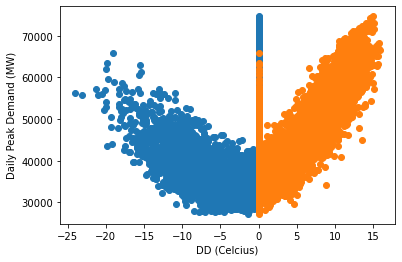

In [8]:
fig, ax = plt.subplots()
ax.scatter(-1.*dy['HDD'], dy['pk_dem'])
ax.scatter(dy['CDD'], dy['pk_dem'])
ax.set_xlabel('DD (Celcius)')
ax.set_ylabel('Daily Peak Demand (MW)')
plt.show()

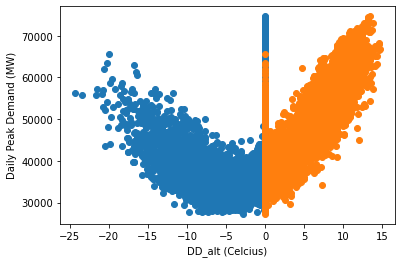

In [9]:
fig, ax = plt.subplots()
ax.scatter(-1.*dy['HDD_alt'], dy['pk_dem'])
ax.scatter(dy['CDD_alt'], dy['pk_dem'])
ax.set_xlabel('DD_alt (Celcius)')
ax.set_ylabel('Daily Peak Demand (MW)')
plt.show()

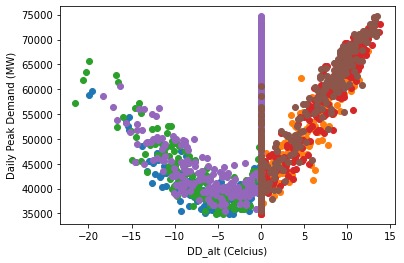

In [10]:
ba_info = return_file_info_map( ba )
years = ba_info['years']
years = [2017, 2018, 2019]

fig, ax = plt.subplots()
for yr in years:
    t = dy.loc[ dy['year'] == yr ]
    ax.scatter(-1.*t['HDD_alt'], t['pk_dem'])
    ax.scatter(t['CDD_alt'], t['pk_dem'])
ax.set_xlabel('DD_alt (Celcius)')
ax.set_ylabel('Daily Peak Demand (MW)')
plt.show()